In [1]:
import math
import numpy as np
from shapely.geometry import Polygon,Point
from shapely.validation import make_valid
from matplotlib import pyplot as plt
import pandas as pd
from tqdm import tqdm
import json
import geopandas as gpd
np.seterr(divide='ignore', invalid='ignore')
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import geopandas as gpd
import utm #pip install utm
from pyproj import CRS
from shapely.geometry import Polygon, Point, LineString
from math import atan2, degrees
import time

In [2]:
# Function to convert Footprint2D string to list of points
def footprint_to_polygon(footprint_str):
    points = [tuple(list(map(float, point.split(',')))[::-1]) for point in footprint_str.split()]
    return Polygon(points)
def convert_footprint_to_points(footprint):
    points = footprint.split('_')
    point_tuples = [tuple(map(float, point.split('/'))) for point in points]
    return point_tuples
def convert_polygon_to_tuples(polygon):
    # Extract the exterior coordinates of the polygon
    coords = list(polygon.exterior.coords)
    return coords

In [3]:
def calculate_geometry_metrics(coords, geom_type='Polygon'):
    if geom_type == 'Polygon':
        geom = Polygon(coords)
        centroid = geom.centroid
        area = geom.area
        return area, (centroid.x, centroid.y)
    elif geom_type == 'LineString':
        geom = LineString(coords)
        length = geom.length
        midpoint_x = (coords[0][0] + coords[1][0]) / 2
        midpoint_y = (coords[0][1] + coords[1][1]) / 2
        return length, (midpoint_x, midpoint_y)
def calculate_azimuth(point1, point2):
    dx = point2[0] - point1[0] # x is longtitude, this calculates diff in long
    dy = point2[1] - point1[1] # latitude
    azimuth = degrees(atan2(dy, dx))
    azimuth = (azimuth-90)% 360  # Ensure the angle is between 0 and 360 degrees
    return azimuth

def calculate_angle_with_x_axis(p1, p2, p3):
    v1 = np.array(p2) - np.array(p1)
    v2 = np.array(p3) - np.array(p1)
    normal_vector = np.cross(v1, v2)
    x_axis = np.array([1, 0, 0])
    dot_product = np.dot(normal_vector, x_axis)
    normal_vector_magnitude = np.linalg.norm(normal_vector)
    cos_angle = dot_product / (normal_vector_magnitude * np.linalg.norm(x_axis))
    cos_angle = np.clip(cos_angle, -1.0, 1.0)
    angle = np.arccos(cos_angle) * (180 / np.pi)
    return angle

def calculate_normal_vector(points):
    v1 = points[1] - points[0]
    v2 = points[2] - points[0]
    return np.cross(v1, v2)


def rotate_to_xy(points):
    normal_vector = calculate_normal_vector(points)
    theta = -np.arctan2(normal_vector[1], normal_vector[0])
    if np.isclose(theta, np.pi/2, atol=1e-2) or np.isclose(theta, -np.pi/2, atol=1e-2):
        rotated_points = points[:, [0, 2]]
    elif np.isclose(theta, 0, atol=1e-2) or np.isclose(theta, np.pi, atol=1e-2) or np.isclose(theta, -np.pi, atol=1e-2):
        rotated_points = points[:, [1, 2]]
    else:
        Rz = np.array([
            [np.cos(theta), -np.sin(theta), 0],
            [np.sin(theta), np.cos(theta), 0],
            [0, 0, 1]
        ])
        rotated_points = np.dot(points, Rz.T)
        rotated_points = rotated_points[:, 1:]
    return rotated_points, theta

def rotate_follow(points, theta):
    if np.isclose(theta, np.pi/2, atol=1e-2) or np.isclose(theta, -np.pi/2, atol=1e-2):
        rotated_points = points[:, [0, 2]]
    elif np.isclose(theta, 0, atol=1e-2) or np.isclose(theta, np.pi, atol=1e-2) or np.isclose(theta, -np.pi, atol=1e-2):
        rotated_points = points[:, [1, 2]]
    else:
        theta_rad = np.radians(theta) if abs(theta) > np.pi else theta
        Rz = np.array([
            [np.cos(theta_rad), -np.sin(theta_rad), 0],
            [np.sin(theta_rad), np.cos(theta_rad), 0],
            [0, 0, 1]
        ])
        rotated_points = np.dot(points, Rz.T)
        rotated_points = rotated_points[:, 1:]
    return rotated_points


def get_cos_theta(points):
    normal_vector = calculate_normal_vector(points)
    theta = -np.arctan2(normal_vector[1], normal_vector[0])
    cos_theta = np.cos(theta)
    # 定义阈值来判断 cos_theta 是否接近0
    threshold = 1e-2
    if np.abs(cos_theta) < threshold:
        return 1
    else:
        return cos_theta
        
def calculate_intersections(PA, PB, D):
    nA = calculate_normal_vector(PA)
    nB = calculate_normal_vector(PB)
    dA = -np.dot(nA, PA[0])
    dB = -np.dot(nB, PB[0])

    if abs(np.dot(nA, PA[3]) + dA) > 1e-6:
        raise ValueError('Fourth point does not lie on Plane A')
    if abs(np.dot(nB, PB[3]) + dB) > 1e-6:
        raise ValueError('Fourth point does not lie on Plane B')

    intersections = np.zeros((4, 3))
    for i in range(4):
        t = -(np.dot(nB, PA[i]) + dB) / np.dot(nB, D)
        intersections[i] = PA[i] + t * D
    return intersections

def is_behind(source, target, sun_direction):
    vector_a = np.array(source[0]) - np.array(target[0])
    return np.dot(vector_a, sun_direction) > 0

def calculate_cosine_2d(points, sun):
    p1, p2, p3 = np.array(points[0]), np.array(points[1]), np.array(points[2])
    v31 = p3 - p1
    v21 = p2 - p1
    normal = np.cross(v31, v21)
    normal_2d = normal[:2] 
    sun_2d = sun[:2]
    l_normal_2d = np.linalg.norm(normal_2d)
    l_sun_2d = np.linalg.norm(sun_2d)
    dian_2d = np.dot(normal_2d, sun_2d)
    cos_2d = dian_2d / (l_normal_2d * l_sun_2d)
    return cos_2d

In [6]:
# solar position
As_list_pd = pd.read_excel('solar azimuth angle.xlsx')
As_list = As_list_pd['Solar\nAzimuth:'].to_list()
hs_list = As_list_pd['Solar\nElevation:'].to_list()
solar_x, solar_y, solar_z = As_list_pd['solar_pos_x'].astype(float).to_list(), As_list_pd['solar_pos_y'].astype(float).to_list(), As_list_pd['solar_pos_z'].astype(float).to_list()

In [7]:
raw = pd.read_csv('SF.csv')
data4shading = raw[['ID', 'Footprint2D', 'Height', 'WWR_surfaces', 'lat', 'lon']].copy()

data4shading.loc[:, 'FootprintPoints'] = data4shading['Footprint2D'].apply(convert_footprint_to_points)
data4shading.loc[:, 'FootprintPointsStr'] = data4shading['FootprintPoints'].apply(
    lambda x: ' '.join([f"{pt[0]},{pt[1]}" for pt in x])
)
data4shading.loc[:, 'geometry'] = data4shading['FootprintPointsStr'].apply(footprint_to_polygon)

gdf = gpd.GeoDataFrame(data4shading, geometry='geometry')
gdf.set_crs(epsg=4326, inplace=True)
utm_crs = gdf.estimate_utm_crs()
print(utm_crs)
gdf = gdf.to_crs(utm_crs)
gdf['geometry_points'] = gdf.geometry.centroid

gdf['lat_utm'] = gdf['geometry_points'].y
gdf['lon_utm'] = gdf['geometry_points'].x
gdf['coordinates'] = gdf['geometry'].apply(convert_polygon_to_tuples)

gdf.head(2)

EPSG:32610


ID                                        Footprint2D  \
0  90032007980815  37.799329/-122.447322_37.799362/-122.447029_37...   
1  90032007980816  37.79428/-122.437969_37.794291/-122.437867_37....   

       Height                                       WWR_surfaces        lat  \
0   61.992934    .15_.15_.15_.15_.15_.15_.15_.15_.15_.15_.15_.15  37.799148   
1  111.365812  .33_.33_.33_.33_.33_.33_.33_.33_.33_.33_.33_.3...  37.794191   

          lon                                    FootprintPoints  \
0 -122.447165  [(37.799329, -122.447322), (37.799362, -122.44...   
1 -122.437547  [(37.79428, -122.437969), (37.794291, -122.437...   

                                  FootprintPointsStr  \
0  37.799329,-122.447322 37.799362,-122.447029 37...   
1  37.79428,-122.437969 37.794291,-122.437867 37....   

                                            geometry  \
0  POLYGON ((548655.767 4183694.366, 548681.540 4...   
1  POLYGON ((549482.545 4183139.091, 549491.518 4...   

                  geometry_points       lat_utm        lon_utm  \
0  POINT (548669.716 4183674.384)  4.183674e+06  548669.715686   
1  POINT (549519.793 4183129.454)  4.183129e+06  549519.792754   

                                         coordinates  
0  [(548655.7668084321, 4183694.3661477994), (548...  
1  [(549482.5453899564, 4183139.0911058243), (549...

(7, 13)
Grid cell (0, 0) contains 7 buildings
7
[549160.76764374 549231.50307251 549231.41103142 549254.46131479
 549251.35574942 549243.08526402 549243.08659078 549236.66473189
 549235.11130707 549217.86717735 549218.14329664 549210.57663778
 549211.67249046 549180.52784526 549181.07410374 549173.86033483
 549172.30830488 549156.47179089 549160.76764374] [4181378.88569637 4181390.40354609 4181391.06871503 4181394.86799049
 4181413.48955503 4181412.21961512 4181411.99771667 4181410.84978989
 4181420.27152454 4181417.50557697 4181415.51006967 4181414.35532184
 4181407.81563178 4181402.74765085 4181399.75517702 4181398.49161741
 4181407.69146459 4181405.15595708 4181378.88569637]
[549178.56377356 549181.59368422 549189.24837919 549188.9722678
 549193.54747049 549192.81117114 549195.62713716 549196.90903706
 549202.80449455 549202.61842956 549226.63922302 549225.90422882
 549231.44743173 549230.71110854 549240.38919221 549239.01123042
 549178.56377356] [4181466.20114432 4181445.4709914  4

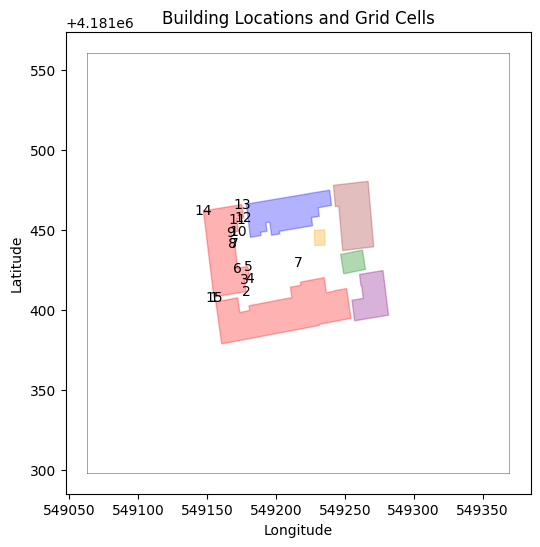

7


In [9]:

test_data_df = pd.read_csv('test_case_ORNL.csv')

test_case = '2_1'
sample_lat = test_data_df[test_data_df['index']==test_case]['sample_lat'].values[0]
sample_lon = test_data_df[test_data_df['index']==test_case]['sample_lon'].values[0]
threshold = test_data_df[test_data_df['index']==test_case]['radius'].values[0]

# Filter the DataFrame
SF_filtered = gdf[(gdf['lat_utm'] > (sample_lat - threshold)) & (gdf['lat_utm'] < (sample_lat + threshold)) &
                 (gdf['lon_utm'] > (sample_lon - threshold)) & (gdf['lon_utm'] < (sample_lon + threshold))]
test = SF_filtered
print(test.shape)

test.loc[:, 'FootprintPointsStr'] = test['coordinates'].apply(
    lambda x: ' '.join([f"{pt[0]},{pt[1]}" for pt in x])
)

test[['ID', 'Height', 'coordinates']].to_csv('ORNL563_forGH.csv', index=False)

xxx_xy=[]
xxx=[]
xxx_gaodu=[]
for index, row in test.iterrows():
    # border_points = row['formatted_geometry']
    # height = row['hgt_median_m']
    border_points = row['coordinates']
    height = row['Height']
    
    x, y = zip(*border_points)
    x=list(x)
    y=list(y)
    arrayx = np.array(x)[::-1]
    arrayy = np.array(y)[::-1]
    z=np.zeros(len(list(x)))
    z_height=[height]*(len(list(x)))
    zuobiao_xy=zip(list(arrayx),list(arrayy))
    zuobiao=zip(list(arrayx),list(arrayy),list(z))
    zuobiao_gaodu=zip(list(arrayx),list(arrayy),list(z_height))
    xxx_xy.append(list(zuobiao_xy))
    xxx.append(list(zuobiao))
    xxx_gaodu.append(list(zuobiao_gaodu))    
#define analysis area
num_cell = 1
buildings_analysis_xy=[ [ [] for j in range(num_cell) ] for i in range(num_cell) ]
buildings_analysis=[ [ [] for j in range(num_cell) ] for i in range(num_cell) ]
buildings_analysis_height=[ [ [] for j in range(num_cell) ] for i in range(num_cell) ]
bounds = [[0]*num_cell for _ in range(num_cell)]
bounds
offset = 100
lat_max = test['lat_utm'].max()+offset
lat_min = test['lat_utm'].min()-offset
lon_max = test['lon_utm'].max()+offset
lon_min = test['lon_utm'].min()-offset

lat_step = (lat_max - lat_min) / num_cell
lon_step = (lon_max - lon_min) / num_cell
num_building = 0
for i in range(0,num_cell,1):
    for j in range(0,num_cell,1):
        bounds[i][j] = [lon_min + i * lon_step, lat_min + j * lat_step, lon_min + (i + 1) * lon_step, lat_min + (j + 1) * lat_step]
        for t in range(len(xxx)):
            #filter the buildings
            center=np.mean(np.array(xxx[t]),axis=0)
            if center[0]> bounds[i][j][0] and center[0] <=  bounds[i][j][2] and center[1] >  bounds[i][j][1] and center[1] <=  bounds[i][j][3]:
                buildings_analysis_xy[i][j].append(xxx_xy[t])
                buildings_analysis[i][j].append(xxx[t])
                buildings_analysis_height[i][j].append(xxx_gaodu[t])
                num_building +=1
for i in range(num_cell):
    for j in range(num_cell):
        if buildings_analysis[i][j]:  # If there are any buildings in the cell
            print(f"Grid cell ({i}, {j}) contains {len(buildings_analysis[i][j])} buildings")
        # else:
        #     print(f"Grid cell ({i}, {j}) NOT contains buildings")
print(len(xxx))
# print(num_building)
# Plotting the grid and buildings
fig, ax = plt.subplots(figsize=(6,6))

# Plot the grid
for i in range(num_cell + 1):
    plt.plot([lon_min, lon_max], [lat_min + i * lat_step, lat_min + i * lat_step], color='black',linewidth = 0.5, alpha = 0.5)
for j in range(num_cell + 1):
    plt.plot([lon_min + j * lon_step, lon_min + j * lon_step], [lat_min, lat_max], color='black',linewidth = 0.5, alpha = 0.5)

# Plot the buildings with polylines
colors = ['red', 'blue', 'green', 'orange', 'purple', 'brown']  # Define some colors for different buildings
for t, building in enumerate(xxx_xy):
    building = np.array(building)
    # plt.plot(building[:, 0], building[:, 1], marker='o', linestyle='-', color=colors[t % len(colors)], label=f'Building {t}')
    plt.fill(building[:, 0], building[:, 1], color=colors[t % len(colors)], alpha=0.3)  # Fill the polygon for better visualization
    print(building[:, 0], building[:, 1])
for idx, (x, y) in enumerate(building):
    plt.text(x, y, f'{idx + 1}', fontsize=10, color='black', ha='center', va='center')

numbuilding = 0
# Annotate grid cells with building count
for i in range(num_cell):
    for j in range(num_cell):
        if buildings_analysis[i][j]:  # If there are any buildings in the cell
            numbuilding += len(buildings_analysis[i][j])
            cell_center_lat = (bounds[i][j][1] + bounds[i][j][3]) / 2
            cell_center_lon = (bounds[i][j][0] + bounds[i][j][2]) / 2
            ax.text(cell_center_lon, cell_center_lat, f"{len(buildings_analysis[i][j])}", 
                    color='black', fontsize=10, ha='center', va='center')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
title = 'Building Locations and Grid Cells'
plt.title(title)
plt.show()
# plt.savefig(f'{title}.png',bbox_inches='tight',transparent=True)
print(numbuilding)

In [10]:
# 测试数据组
# r=0
# w=0
# q=0
# buildings_analysis[r][w][q]=[(41, 54, 0.0), (46, 54, 0.0), (50, 66, 0.0), (54, 66, 0.0), (55, 69, 0.0), (45, 69, 0.0), (41, 54, 0.0)]
# buildings_analysis_xy[r][w][q]=[(41, 54), (46, 54), (50, 66), (54, 66), (55, 69), (45, 69), (41, 54)]
# buildings_analysis_height[r][w][q]=[(41, 54, 80), (46, 54, 80), (50, 66, 80), (54, 66, 80), (55, 69, 80), (45, 69, 80), (41, 54, 80)]
# buildings_analysis[r][w][q]=[(41, 54, 0.0), (51, 54, 0.0), (51, 69, 0.0), (41, 69, 0.0), (41, 54, 0.0)]
# buildings_analysis_xy[r][w][q]=[(41, 54), (51, 54), (51, 69), (41, 69), (41, 54)]
# buildings_analysis_height[r][w][q]=[(41, 54, 40), (51, 54, 40), (51, 69, 40), (41, 69, 40), (41, 54, 40)]



# r=0
# w=0
# q=1
# buildings_analysis[r][w][q]=[(63.5, 62, 0.0), (73.5, 62, 0.0), (75, 69, 0.0), (65, 69, 0.0), (63.5, 62, 0.0)]
# buildings_analysis_xy[r][w][q]=[(63.5, 62), (73.5, 62), (75, 69), (65, 69), (63.5, 62)]
# buildings_analysis_height[r][w][q]=[(63.5, 62, 80), (73.5, 62, 80), (75, 69, 80), (65, 69, 80), (63.5, 62, 80)]



###################################################################################################################



# r=0
# w=0
# q=0
# buildings_analysis[r][w][q]=[(41, 54, 0.0), (51, 54, 0.0), (51, 69, 0.0), (41, 69, 0.0), (41, 54, 0.0)]
# buildings_analysis_xy[r][w][q]=[(41, 54), (51, 54), (51, 69), (41, 69), (41, 54)]
# buildings_analysis_height[r][w][q]=[(41, 54, 40), (51, 54, 40), (51, 69, 40), (41, 69, 40), (41, 54, 40)]


# r=0
# w=0
# q=1
# buildings_analysis[r][w][q]=[(61, 54, 0.0), (71, 54, 0.0), (71, 69, 0.0), (61, 69, 0.0), (61, 54, 0.0)]
# buildings_analysis_xy[r][w][q]=[(61, 54), (71, 54), (71, 69), (61, 69), (61, 54)]
# buildings_analysis_height[r][w][q]=[(61, 54, 50), (71, 54, 50), (71, 69, 50), (61, 69, 50), (61, 54, 50)]


In [13]:
buildings_analyzed = 0
unique_building_id = 0
results = {}
building_loc_metadata = {}
building_loc = []
start_time = time.time()
for r in range(0,num_cell,1):
    for w in range(0,num_cell,1):
        for q in tqdm(range(len(buildings_analysis[r][w]))):
            cell_key = f'cell_{r}_{w}'
            building_key = f'building_{unique_building_id}'
            cell_key_loc = f'cell_{r}_{w}'
            building_key_loc = f'building_{unique_building_id}'
            if cell_key not in building_loc_metadata:
                building_loc_metadata[cell_key] = {}
            if building_key not in building_loc_metadata[cell_key]:
                building_loc_metadata[cell_key][building_key] = {
                    'roof_loc': None,
                    'facade_loc': {},
                    'facade_azimuth': {}
                }
            building_target = np.array(buildings_analysis[r][w][q])
            building_target_xy = np.array(buildings_analysis_xy[r][w][q])
            building_target_dingmian = np.array(buildings_analysis_height[r][w][q])
            s_roof_value = 0
            original_roof_area, roof_centroid = calculate_geometry_metrics(building_target_xy, geom_type='Polygon')
            original_facade_areas = []
            facade_azimuths = []
            facade_loc = []
            building_loc.append(building_target_xy)
            building_loc_metadata[cell_key][building_key]['roof_loc'] = building_target_xy
            for u in range(len(building_target) - 1):
                
                segment_length, segment_midpoint = calculate_geometry_metrics([building_target[u], building_target[u + 1]], geom_type='LineString')
                height = building_target_dingmian[u][2]  # Assuming the height is the z-coordinate
                facade_area = segment_length * height
                original_facade_areas.append(facade_area)
                azimuth = calculate_azimuth(building_target[u], building_target[u + 1])
                facade_azimuths.append(azimuth)
                facade_loc.append(segment_midpoint)
            building_loc_metadata[cell_key][building_key]['facade_loc'] = facade_loc
            building_loc_metadata[cell_key][building_key]['facade_azimuth'] = facade_azimuths

            # Calculate cos values for BASE coordinates
            cos_=[]
            for l in range(0,len(building_target)-1,1):
                f_l=np.array(building_target_xy[l+1])-np.array(building_target_xy[l])
                xx=np.array([1,0])
                l_xx=np.sqrt(xx.dot(xx))
                l_f_l=np.sqrt(f_l.dot(f_l))
                dian=xx.dot(f_l)
                cos_.append(dian/(l_xx*l_f_l))

            p1=Polygon(building_target_xy)     
            xmin=p1.bounds[0]
            ymin=p1.bounds[1]
            xmax=p1.bounds[2]
            ymax=p1.bounds[3]
            cx1=(xmin+xmax)/2
            cy1=(ymin+ymax)/2
            pc1=Point(cx1,cy1)
            
            round_r = max(pc1.distance(Point(coord)) for coord in building_target_xy)
            
            lat=38
            p=math.pi

            for k in range (164,165):
                for i in range(24):
                    hs = hs_list[i] 
                    if hs<=0:
                        continue
                    As = As_list[i]
                    # sun=np.array([-math.sin(As*p/180)*math.cos(hs*p/180),-math.cos(As*p/180)*math.cos(hs*p/180),-math.sin(hs*p/180)])
                    sun = np.array([-solar_x[i], -solar_y[i], -solar_z[i]])
                    s_roof=Polygon()
                    s_facade=[Polygon()]*(len(building_target)-1)
                    s_facade_value=[0]*(len(building_target)-1)
                    #筛选目标建筑向阳面及背阴面
                    u_box=[]
                    us_box=[]
                    for u in range(0,len(building_target)-1,1):
                        points = [building_target[u], building_target[u+1], building_target_dingmian[u]]
                        cosine_value = calculate_cosine_2d(points, sun)
                        if cosine_value > 0: 
                            u_box.append(u)
                        elif cosine_value  < 0:
                            us_box.append(u)               
                    #筛选目标建筑会被自己遮挡的向阳面 （所有向阳面）
                    u_mian=u_box
                    # print(u_box)

                    #求自遮挡 背阴面对向阳面的遮挡
                    for h in range(0,len(u_mian),1):    
                        mm=u_mian[h]
                        Planefrom4points = [building_target[mm],building_target[mm+1],building_target_dingmian[mm+1],building_target_dingmian[mm]]
                        rotated_Planefrom4points, theta = rotate_to_xy(np.array(Planefrom4points))
                        polygon_facade = Polygon(rotated_Planefrom4points)
                        for e in range(0,len(u_box),1):
                            u=u_box[e]
                            if u!=mm: 
                                Planefrom4points_us = [building_target[u],building_target[u+1],building_target_dingmian[u+1],building_target_dingmian[u]]
                                if is_behind(Planefrom4points_us, Planefrom4points, sun):
                                    continue        
                                intersections = calculate_intersections(np.array(Planefrom4points_us), np.array(Planefrom4points), sun)
                                rotated_Coordinate4points = rotate_follow(intersections, theta)
                                cos = get_cos_theta(np.array(Planefrom4points))
                                targetbd = Polygon(rotated_Coordinate4points)
                                s_facade[mm] = s_facade[mm].union(targetbd) # 合并几何图形
                        s_facade[mm] = polygon_facade.intersection(s_facade[mm]) # 计算重合面积
                        s_facade_value[mm] = s_facade[mm].area
    
                    #一栋一栋求邻域建筑的阴影
                    for n in range(len(buildings_analysis[r][w])):
                        if n==q:
                            continue
                        if n!=q:
                            building_near_xy=buildings_analysis_xy[r][w][n]
                            building_near=buildings_analysis[r][w][n]
                            building_near_dingmian=buildings_analysis_height[r][w][n]
                        # print(n)    
                        cxn=(Polygon(building_near_xy).bounds[0]+Polygon(building_near_xy).bounds[2])/2
                        cyn=(Polygon(building_near_xy).bounds[1]+Polygon(building_near_xy).bounds[3])/2
                        pcn=Point(cxn,cyn)
                        dis_bds=pc1.distance(pcn)-round_r
                        Hmax=building_near_dingmian[0][2]/math.tan(hs*p/180)
                        # if dis_bds > Hmax or Polygon(building_near_xy).bounds[2] <= p1.bounds[0] or Polygon(building_near_xy).bounds[3] <= p1.bounds[1]:
                          #   continue
                            
                        #筛选邻域建筑背阴面
                        z_box=[]    
                        for z in range(0,len(building_near)-1,1):
                            points = [building_near[z], building_near[z+1], building_near_dingmian[z]]
                            cosine_value = calculate_cosine_2d(points, sun)
                            if cosine_value < 0: 
                                z_box.append(z)  
                        
                        #邻域建筑背阴面的顶点跟目标建筑第u个向阳面的交点
                        for e in range(0,len(u_box),1):
                            u=u_box[e]
                            Planefrom4points = [building_target[u],building_target[u+1],building_target_dingmian[u+1],building_target_dingmian[u]]
                            rotated_Planefrom4points, theta = rotate_to_xy(np.array(Planefrom4points))
                            polygon_facade = Polygon(rotated_Planefrom4points)
                            for g in range(0,len(z_box),1):
                                k = z_box[g]
                                Planefrom4points_us = [building_near[k],building_near[k+1],building_near_dingmian[k+1],building_near_dingmian[k]]      
                                if is_behind(Planefrom4points_us, Planefrom4points, sun):
                                    continue        
                                intersections = calculate_intersections(np.array(Planefrom4points_us), np.array(Planefrom4points), sun)
                                rotated_Coordinate4points = rotate_follow(intersections, theta)
                                cos = get_cos_theta(np.array(Planefrom4points))
                                targetbd = Polygon(rotated_Coordinate4points)
                                s_facade[u] = s_facade[u].union(targetbd) # 合并几何图形
                            s_facade[u] = polygon_facade.intersection(s_facade[u]) # 计算重合面积
                            s_facade_value[u] = s_facade[u].area 
                        

                        # 计算屋顶
                        Planefrom4points = [building_target_dingmian[0],building_target_dingmian[1],building_target_dingmian[2],building_target_dingmian[3]]
                        polygon_roof = Polygon(building_target_dingmian)
                        H_value_to_assign = building_target_dingmian[0][2]
                        H_value_near_building = building_near_dingmian[0][2]
                        if H_value_to_assign > H_value_near_building:
                            continue  
                        for g in range(0,len(z_box),1):
                            k = z_box[g]
                            Planefrom4points_us = [list(building_near[k]),list(building_near[k+1]),
                                                   list(building_near_dingmian[k+1]),list(building_near_dingmian[k])]
                            Planefrom4points_us[0][2] = H_value_to_assign
                            Planefrom4points_us[1][2] = H_value_to_assign
                            if is_behind(Planefrom4points_us, Planefrom4points, sun):
                                continue        
                            intersections = calculate_intersections(np.array(Planefrom4points_us), np.array(Planefrom4points), sun)
                            targetbd = Polygon(intersections)
                            s_roof = s_roof.union(targetbd) # 合并几何图形
                        s_roof = polygon_roof.intersection(s_roof)
                        s_roof_value = s_roof.area

                   
                    for e in range(0,len(u_box),1):
                        u=u_box[e]
                    #     print("目标建筑第",u,"个立面的总阴影面积是：",s_facade_value[u])
                    # print("目标建筑顶面的总阴影面积是：",s_roof_value)
                    
                    cell_key = f'cell_{r}_{w}'
                    building_key = f'building_{int(original_roof_area)}'
                    day_key = f'day_{k}'
                    hour_key = f'hour_{i}'
                    if cell_key not in results:
                        results[cell_key] = {}
                    if building_key not in results[cell_key]:
                        results[cell_key][building_key] = {}
                    if day_key not in results[cell_key][building_key]:
                        results[cell_key][building_key][day_key] = {}
                    if hour_key not in results[cell_key][building_key][day_key]:
                        results[cell_key][building_key][day_key][hour_key] = {
                            f'{int(original_roof_area)}_roof': original_roof_area,
                            'facade': {},
                        }
                    for e in range(len(u_box)):
                        u = u_box[e]
                        shading_area = s_facade_value[u]
                        remaining_area = original_facade_areas[u] - shading_area
                        results[cell_key][building_key][day_key][hour_key]['facade'][int(original_facade_areas[u])] = s_facade_value[u]

                    shading_area_roof = s_roof_value
                    remaining_roof_area = original_roof_area - shading_area
                    results[cell_key][building_key][day_key][hour_key][f'{int(original_roof_area)}_roof'] = s_roof_value

                    buildings_analyzed += 1
            unique_building_id +=1
print(unique_building_id)
end_time = time.time()
elapsed_time = end_time - start_time

with open(f'results/{test_case}_results_original_code_time_{elapsed_time:.3f}.json', 'w') as json_file:
    json.dump(results, json_file, indent=4)

def convert_to_list(item):
    if isinstance(item, np.ndarray):
        return item.tolist()
    elif isinstance(item, dict):
        return {key: convert_to_list(value) for key, value in item.items()}
    elif isinstance(item, list):
        return [convert_to_list(element) for element in item]
    else:
        return item

# 应用转换
building_loc_metadata_converted = convert_to_list(building_loc_metadata)

# 现在保存为 JSON
with open(f'results/{test_case}_results_building_loc_original_code_time_{elapsed_time:.3f}.json', 'w') as json_file:
    json.dump(building_loc_metadata_converted, json_file, indent=4)

print(f"Result saved to results/{test_case}_results_building_loc_original_code_time_{elapsed_time:.3f}.json")

100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:07<00:00,  1.01s/it]

7
Result saved to results/2_1_results_building_loc_original_code_time_7.041.json
